In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
sched = pd.read_csv('MatchStats6Year.csv')
sched.head()

,Date,Opponent,S,Kills,Errors,Total Attacks,Hit Pct,Assists,Aces,SErr,...,Block Solos,Block Assists,BErr,PTS,BHE,Team,Sets Won,Sets Lost,Match Result,Location
0,08/30/2019,UT Arlington,5,58,22,156,0.231,45,10,10,...,2,4,0,72.0,1,A&M-Corpus Christi,2,3,L,Neutral
1,08/30/2019,Houston,3,49,16,112,0.295,48,4,6,...,0,2,0,0.0,0,A&M-Corpus Christi,3,0,W,Neutral
2,08/31/2019,Arizona St.,4,46,17,147,0.197,37,2,5,...,1,0,0,49.0,3,A&M-Corpus Christi,1,3,L,Neutral
3,09/04/2019,UTRGV,5,61,26,167,0.210,57,6,9,...,4,6,0,74.0,2,A&M-Corpus Christi,2,3,L,Neutral
4,09/06/2019,New Mexico,3,48,12,104,0.346,41,2,7,...,0,6,0,53.0,0,A&M-Corpus Christi,3,0,W,Neutral


In [3]:
home = sched[sched['Location'] == 'Home'].copy()
away = sched[sched['Location'] == 'Away'].copy()
neutral = sched[sched['Location'] == 'Neutral'].copy()
print(home.shape, away.shape, neutral.shape)

(16285, 22) (15823, 22) (29031, 22)


In [4]:
neutral_stack_home = neutral.set_index(['Date', 'Team', 'Opponent']).stack().reset_index()
neutral_stack_home.columns = ['Date', 'Home', 'Away', 'Stat', 'HomeValue']
neutral_stack_home.set_index(['Date', 'Home', 'Away', 'Stat'], inplace=True)

In [5]:
neutral_stack_away = neutral.set_index(['Date', 'Team', 'Opponent']).stack().reset_index()
neutral_stack_away.columns = ['Date', 'Away', 'Home', 'Stat', 'AwayValue']
neutral_stack_away.set_index(['Date', 'Home', 'Away', 'Stat'], inplace=True)

In [6]:
comb_neutral = pd.merge(neutral_stack_home, neutral_stack_away, left_index=True, right_index=True)
comb_neutral = comb_neutral[~comb_neutral.index.duplicated()]

In [7]:
home_stack = home.set_index(['Date', 'Team', 'Opponent']).stack().reset_index()
home_stack.columns = ['Date', 'Home', 'Away', 'Stat', 'HomeValue']
home_stack.set_index(['Date', 'Home', 'Away', 'Stat'], inplace=True)

In [8]:
away_stack = away.set_index(['Date', 'Team', 'Opponent']).stack().reset_index()
away_stack.columns = ['Date', 'Away', 'Home', 'Stat', 'AwayValue']
away_stack.set_index(['Date', 'Home', 'Away', 'Stat'], inplace=True)

In [9]:
comb = pd.merge(home_stack, away_stack, left_index=True, right_index=True)
comb = comb[~comb.index.duplicated()]

In [10]:
comb = pd.concat([comb, comb_neutral])

In [11]:
num_stats = ~comb.index.get_level_values(3).isin(['Location', 'Match Result'])
comb.loc[num_stats, 'DiffValue'] = comb.loc[num_stats, 'HomeValue'].astype('float') - comb.loc[num_stats, 'AwayValue'].astype('float')

C:\Users\steve\Documents\WPy64-3760\python-3.7.6.amd64\lib\site-packages\IPython\core\interactiveshell.py:2848: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [12]:
comb = comb.unstack()

In [13]:
idx = pd.IndexSlice
X = comb.loc[:, idx['DiffValue']].reset_index()
X.drop(['Date', 'Home', 'Away', 'Assists', 'Match Result','Location', 'Sets Lost', 'Sets Won'], axis=1, inplace=True)
labels = X.columns.values
Y = (comb.loc[:, idx['HomeValue', 'Match Result']].values == 'W').astype(int)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37753 entries, 0 to 37752
Data columns (total 14 columns):
Aces             37753 non-null float64
BErr             37753 non-null float64
BHE              37753 non-null float64
Block Assists    37753 non-null float64
Block Solos      37753 non-null float64
Digs             37753 non-null float64
Errors           37753 non-null float64
Hit Pct          37753 non-null float64
Kills            37753 non-null float64
PTS              37753 non-null float64
RErr             37753 non-null float64
S                37753 non-null float64
SErr             37753 non-null float64
Total Attacks    37753 non-null float64
dtypes: float64(14)
memory usage: 4.0 MB


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

In [15]:
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(28314, 14) (9439, 14) (28314,) (9439,)


In [17]:
from sklearn.linear_model import LogisticRegression

logreg =  make_pipeline(QuantileTransformer(),
                        LogisticRegression())

logreg.fit(X_train, y_train)
print('LR score for training %.1f%%' % (logreg.score(X_train, y_train)*100))
print('LR score for test %.1f%%' % (logreg.score(X_test, y_test)*100))

LR score for training 94.1%
LR score for test 94.2%


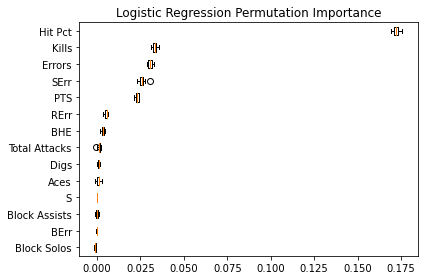

In [18]:
result = permutation_importance(logreg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=labels[sorted_idx])
ax.set_title("Logistic Regression Permutation Importance")
fig.tight_layout()
plt.show()

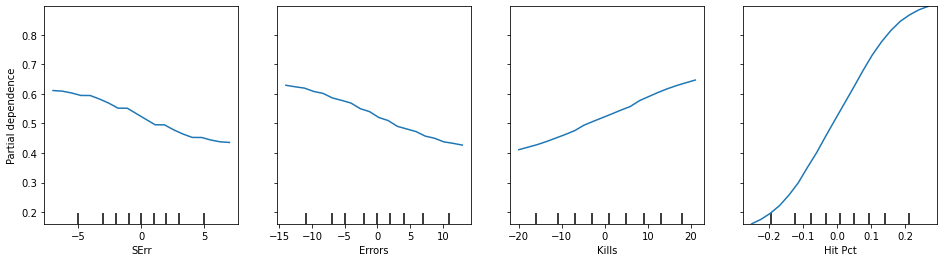

In [19]:
fig, ax = plt.subplots(figsize=(16,4))
plot_partial_dependence(logreg, X_train, labels[sorted_idx[-4:]],
                        n_jobs=3, grid_resolution=20, n_cols=4, ax=ax)

In [20]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(max_iter=100).fit(X_train, y_train)

print('HGB score for training %.1f%%' % (hgb.score(X_train, y_train)*100))
print('HGB score for test %.1f%%' % (hgb.score(X_test, y_test)*100))

HGB score for training 95.9%
HGB score for test 94.0%


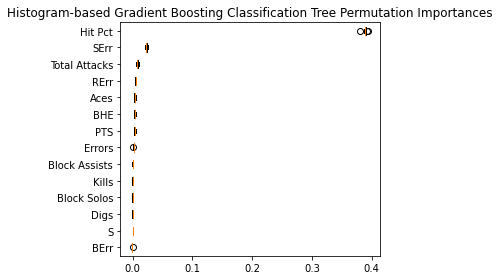

In [21]:
result = permutation_importance(hgb, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=labels[sorted_idx])
ax.set_title("Histogram-based Gradient Boosting Classification Tree Permutation Importances")
fig.tight_layout()
plt.show()

Text(0.5, 0.98, 'HGB Partial Dependence')

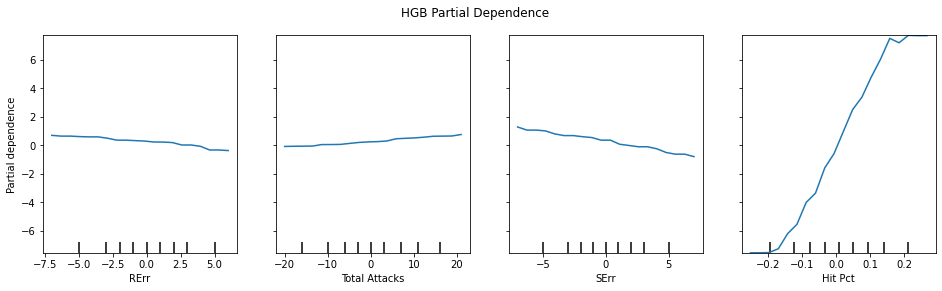

In [22]:
fig, ax = plt.subplots(figsize=(16,4))
plot_partial_dependence(hgb, X_train, labels[sorted_idx[-4:]],
                        n_jobs=3, grid_resolution=20, n_cols=4, ax=ax)
fig.suptitle('HGB Partial Dependence')

In [23]:
from sklearn.linear_model import SGDClassifier

svc = make_pipeline(QuantileTransformer(),
                    SGDClassifier(random_state = 0))

# fit model to training data
svc.fit(X_train, y_train)

print('SVM score for training %.1f%%' % (svc.score(X_train, y_train)*100))
print('SVM score for test %.1f%%' % (svc.score(X_test, y_test)*100))

SVM score for training 94.1%
SVM score for test 94.2%


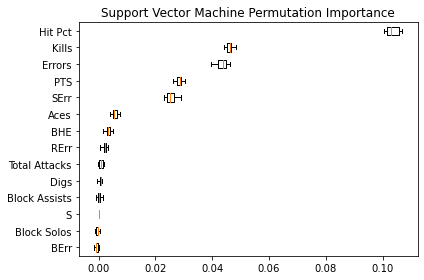

In [24]:
from sklearn.inspection import permutation_importance

result = permutation_importance(svc, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=3)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=labels[sorted_idx])
ax.set_title("Support Vector Machine Permutation Importance")
fig.tight_layout()
plt.show()

Text(0.5, 0.98, 'SVM Partial Dependence')

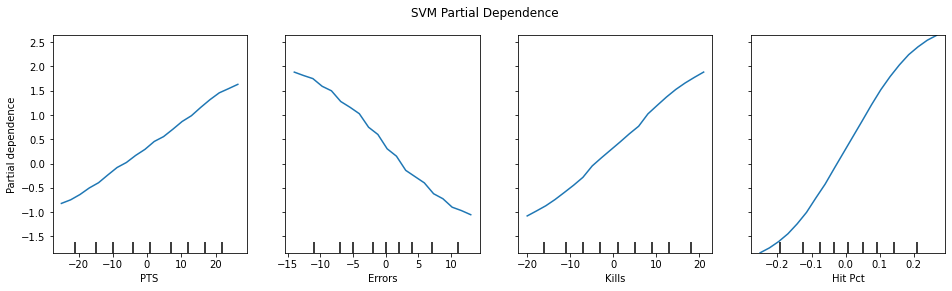

In [25]:
fig, ax = plt.subplots(figsize=(16,4))
plot_partial_dependence(svc, X_train, labels[sorted_idx[-4:]],
                        n_jobs=3, grid_resolution=20, n_cols=4, ax=ax)
fig.suptitle('SVM Partial Dependence')

In [26]:
from sklearn.neural_network import MLPClassifier

mlc = make_pipeline(QuantileTransformer(),
                    MLPClassifier(hidden_layer_sizes=(100, 75),
                    learning_rate_init=0.001,
                    early_stopping=True)).fit(X_train, y_train)

print('MLP score for training %.1f%%' % (mlc.score(X_train, y_train)*100))
print('MLP score for test %.1f%%' % (mlc.score(X_test, y_test)*100))

MLP score for training 94.2%
MLP score for test 94.2%


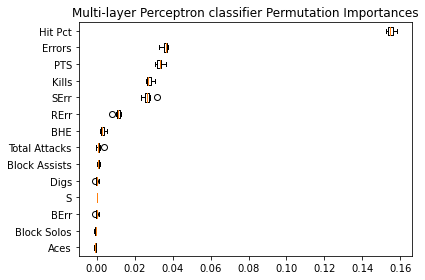

In [27]:
result = permutation_importance(mlc, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=labels[sorted_idx])
ax.set_title("Multi-layer Perceptron classifier Permutation Importances")
fig.tight_layout()
plt.show()

Text(0.5, 0.98, 'MLC Partial Dependence')

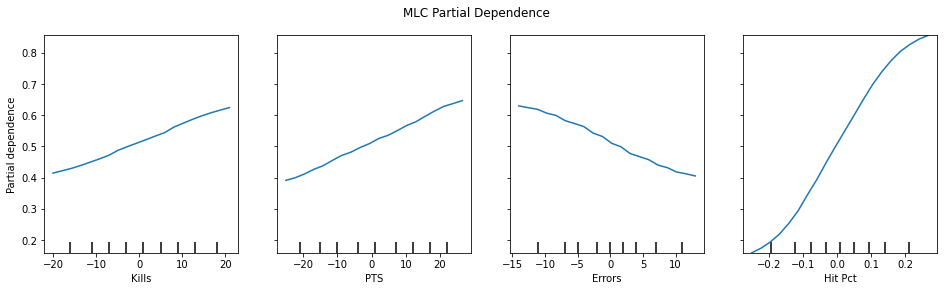

In [28]:
fig, ax = plt.subplots(figsize=(16,4))
plot_partial_dependence(mlc, X_train, labels[sorted_idx[-4:]],
                        n_jobs=3, grid_resolution=20, n_cols=4, ax=ax)
fig.suptitle('MLC Partial Dependence')

In [29]:
temp = comb[[('DiffValue', 'Hit Pct'), ('HomeValue', 'Match Result')]].reset_index()
temp.columns = ['Date', 'Home', 'Away', 'Hit Pct', 'Match Result']

Match Result
L    AxesSubplot(0.125,0.125;0.775x0.755)
W    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Hit Pct, dtype: object

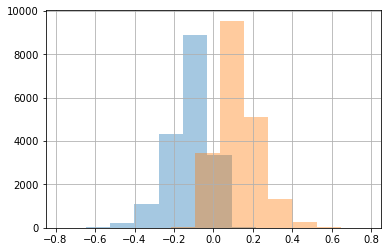

In [30]:
temp.groupby('Match Result')['Hit Pct'].hist(alpha=0.4)

In [32]:
import statsmodels.api as sm
logit_mod = sm.Logit(Y, X)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.137019
         Iterations 18
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                37753
Model:                          Logit   Df Residuals:                    37739
Method:                           MLE   Df Model:                           13
Date:                Tue, 30 Jun 2020   Pseudo R-squ.:                  0.8020
Time:                        12:29:35   Log-Likelihood:                -5172.9
converged:                       True   LL-Null:                       -26126.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Aces             -0.3285      0.102     -3.207      0.001      -0.529      -0.128
BErr             -0